In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import glob

def calibrate_cam():
    ''' function that calibrates camera with a chessboard images 
    returns camera matrix and distortion coefficients'''
    # chessboard corners
    nx = 9
    ny = 6
    
    # object and image points for calibration
    objpoints  = []
    imgpoints  = []
    objp       = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    # loop through 20 calibration images 
    for fname in cal_images:
        # Read calibration image
        gray_img   = cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
            
        if ret == True:
            # extend object and image points
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, cam_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
    return cam_mtx, dist_coeff

def channel_thresh(img_channel, thresh):
    '''generic function for applying thresholding for a single channel'''
    binary = np.zeros_like(img_channel)
    binary[(img_channel > thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary

def sobel_mask(img, mag_thresh=(60, 255), ang_thresh=(np.pi/9, 8*np.pi/9), sobel_kernel=3):
    ''' function returns mask based on gradient-sobel magnitude AND angle '''
    # convert to grayscale
    gray      = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # GaussianBlur low-pass filtering
    gray      = cv2.GaussianBlur(gray,(5,5),0)
    
    # Sobel estimation in x and y directions respectively
    sobelx    = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1 ,0, ksize=sobel_kernel))
    sobely    = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Sobel magnitude
    sobel_mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    sobel_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))
    
    # Sobel angle (relative to horizontal line)
    sobel_ang = np.absolute(np.arctan2(sobelx, sobely))
    
    # Thresholding sobel by magnitude and gradient
    bin_mag   = channel_thresh(sobel_mag, thresh = mag_thresh)
    bin_ang   = channel_thresh(sobel_ang, thresh = ang_thresh)
    bin_res   = np.zeros_like(bin_mag)
    bin_res[(bin_mag == 1) & (bin_ang == 1)] = 1
    return bin_res

def white_mask(hsv_img, sat_thresh=(0, 30), val_thresh=(210, 255)):
    ''' function returns white mask based on S AND V of HSV colorspace'''
   
    bin_sat   = channel_thresh(hsv_img[:,:,1], thresh = sat_thresh)
    bin_val   = channel_thresh(hsv_img[:,:,2], thresh = val_thresh)
    bin_res   = np.zeros_like(bin_sat)
    bin_res[(bin_sat == 1) & (bin_val == 1)] = 1
    return bin_res

def yellow_mask(hsv_img, hue_thresh=(15, 30), sat_thresh=(100, 255)):
    ''' function returns yellow mask based on H AND S of HSV colorspace
        saturated yellow hue is 25 (in 0-180 representation)
        Note that hue_thresh is skewed towards red rather than green
    '''
    
    bin_hue   = channel_thresh(hsv_img[:,:,0], thresh = hue_thresh)
    bin_sat   = channel_thresh(hsv_img[:,:,1], thresh = sat_thresh)
    bin_res   = np.zeros_like(bin_hue)
    bin_res[(bin_hue == 1) & (bin_sat == 1)] = 1
    return bin_res

from numpy.linalg import pinv
def perspective_transform(old_ver, new_ver):
    ''' performs perspective transform on an image based on old and new vertices
    '''
    T        = cv2.getPerspectiveTransform(old_ver, new_ver)
    Tinv     = pinv(T) 
    return T, Tinv

Calibration is completed...


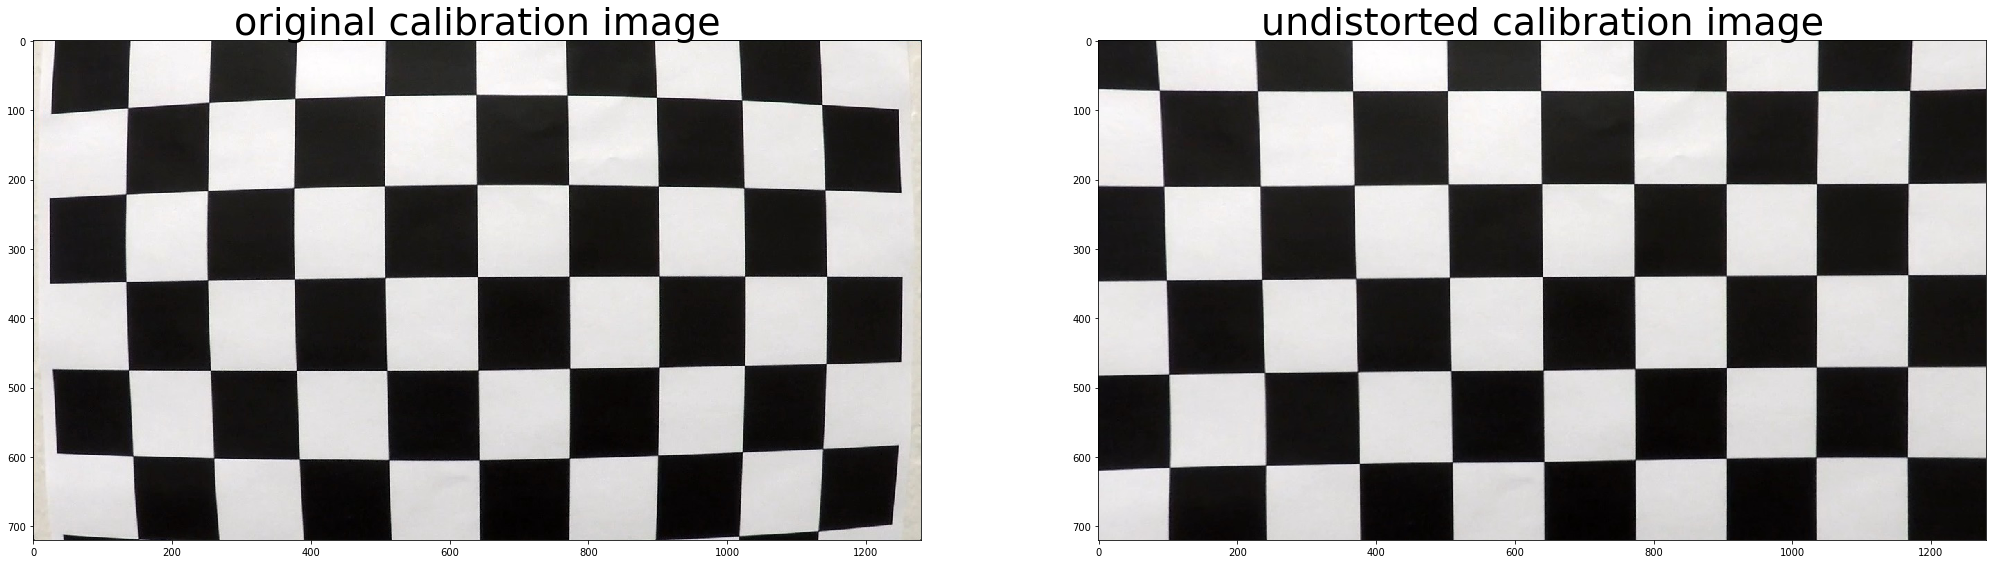

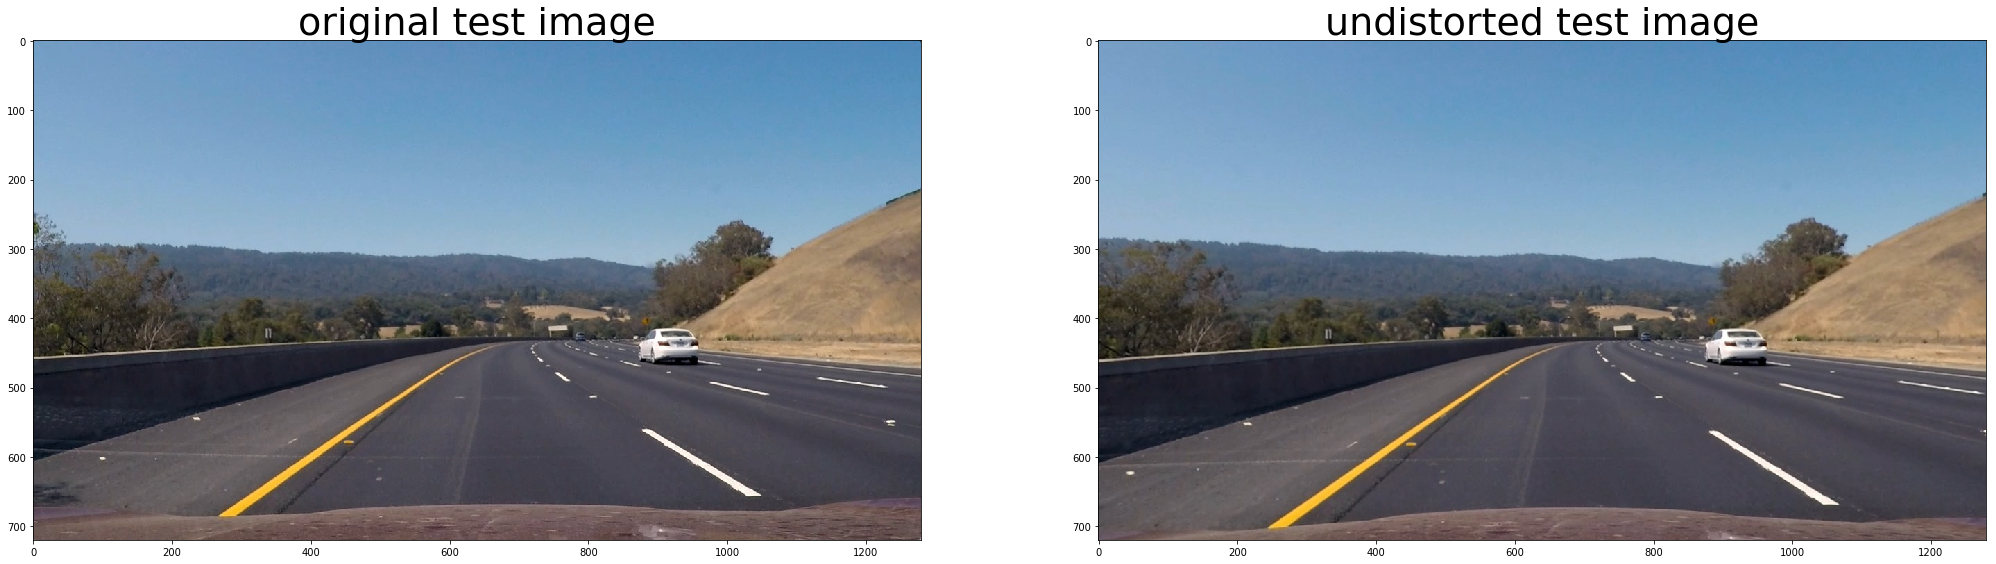

In [2]:
cam_mtx, dist_coeff = calibrate_cam()
print('Calibration is completed...')

# Perspective Transformation vertices 
ver     = np.float32([[254, 696],[585, 458],[702, 458],[1070, 696]])
new_ver = np.float32([[200, 720],[200, 0],[1080, 0],[1080, 720]])
T, Tinv = perspective_transform(ver, new_ver)

# demonstrate undistortion on calibration image
cal_image  = mpimg.imread('camera_cal/calibration1.jpg')
undist_cal = cv2.undistort(cal_image, cam_mtx, dist_coeff, None, cam_mtx)
plt.figure(0)
fig, axs = plt.subplots(ncols=2, figsize=(35,10))
axs[0].imshow(cal_image)
axs[0].set_title('original calibration image', fontsize=38)
axs[1].imshow(undist_cal)
axs[1].set_title('undistorted calibration image', fontsize=38)

                       
# demonstrate undistortion on test image
# demonstrate undistortion on calibration image
test_image  = mpimg.imread('test_images/test3.jpg')
undist_test = cv2.undistort(test_image, cam_mtx, dist_coeff, None, cam_mtx)
plt.figure(1)
fig, axs = plt.subplots(ncols=2, figsize=(35,10))
axs[0].imshow(test_image)
axs[0].set_title('original test image', fontsize=38)
axs[1].imshow(undist_test)
axs[1].set_title('undistorted test image', fontsize=38)

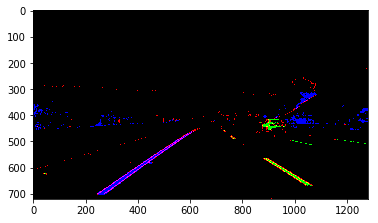

In [3]:
# demonstration of sobel, white and yellow masks!

# hsv colorspace for white and yellow masking
hsv_test = cv2.cvtColor(undist_test, cv2.COLOR_RGB2HSV)
    
# sobel, white and yellow masks respectively
test_sobel   = sobel_mask(undist_test)
test_white   = white_mask(hsv_test)
test_yellow  = yellow_mask(hsv_test)
test_color   = np.dstack((test_sobel, test_white, test_yellow))
plt.figure(0)
plt.imshow(test_color*255)

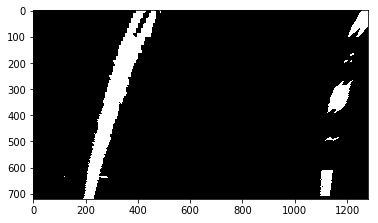

In [4]:
# demonstration of perspective transformation!
test_binary  = (test_sobel | test_white | test_yellow)
test_img_h, test_img_w = test_image.shape[0:2]
# apply perspective transformation for bird-eye view
test_warped  = cv2.warpPerspective(test_binary, T, (test_img_w, test_img_h))
plt.figure(0)
plt.imshow(test_warped,'gray')

In [5]:
conv_wind = (40, 40) # convolution window size (x,y)
conv_step = (10, 20) # convolution step size (dx,dy)

def convolution1D(img, wind = conv_wind, step_x = conv_step[0], x_start = 0, x_end = 1280, offset_y = 0):
    ''' horizontal 1D convolution: return array of convolution values '''
    wind_x, wind_y = wind[:]
    # check that x_start and x_end values are properly set
    assert (x_start >= 0)      and (x_start <= (img.shape[1] - wind_x)), 'x_start is set out of bounds of image - {}'.format(x_start)
    assert (x_end   >= wind_x) and (x_end   <= img.shape[1]), 'x_end is set out of bounds of image - {}'.format(x_end)

    conv_len  = np.int((x_end - x_start - wind_x)/step_x + 1) # length of convolution array
    conv_val  = np.zeros(conv_len, dtype=np.int16)            # convolution results / values
    offset_x = x_start
    for i in range(conv_len):
        conv_val[i] = np.sum(img[offset_y:offset_y+wind_y,offset_x:offset_x+wind_x])
        offset_x += step_x
        
    return conv_val

def detect_peak(conv, threshold):
    '''
    Detects peak in convolution array. Simple maximum is returned as peak
    '''
    peak = None
    if(np.amax(conv) >= threshold):
        peaks_idx = np.argwhere(conv == np.amax(conv)) # find simple maximum
        peak      = np.average(peaks_idx) # average if multiple
        
    return peak

def detect_lanes_pts(img, wind = conv_wind, step = conv_step, x_bound_left = (0, 640), x_bound_right = (640,1280), margin = 100):
    '''Returns left and right lanes points (further used for poly-fit)
       x_bound_left - initial boundaries for searching left lane 
       x_bound_right - initial boundaries for searching right lane
       margin -  +- search margin for next 1D search around detected peak
    '''
    wind_x, wind_y = wind[:] # convolution window in x, and y dimensions respectively
    step_x, step_y = step[:] # convolution step in x and y dimensions respectively
    imgs_x, imgs_y = img.shape[::-1] # image shape 
    peak_thresh    = wind_x * wind_y * 0.05 # threshold for peak detection (at least 10% marked) 
    
    # declare array for storing detected peaks of left and right lanes respectively
    left_lane_pts  = []
    right_lane_pts = []
    
    conv_steps_y = np.int((imgs_y - wind_y)/step_y + 1) # number of convolution steps in y direction
    offset_y     = imgs_y - wind_y # start from the bottom of the image
    
    # convolution1D boundaries in x direction for detection of left and right lanes respectively
    x_start_left    = max(x_bound_left[0], 0)
    x_end_left      = min(x_bound_left[1], imgs_x)
    x_start_right   = max(x_bound_right[0], 0)
    x_end_right     = min(x_bound_right[1], imgs_x)
    
    for i in range(conv_steps_y):
        y_coord      = imgs_y - (wind_y // 2 + i * step_y) 
        conv_left    = convolution1D(img, wind = wind, step_x = step_x, x_start = x_start_left, x_end = x_end_left, offset_y = offset_y)
        conv_right   = convolution1D(img, wind = wind, step_x = step_x, x_start = x_start_right, x_end = x_end_right, offset_y = offset_y)
        
        # finding left lane peak
        x_peak_left  = detect_peak(conv_left, peak_thresh)
        if(x_peak_left is not None):
            x_left_coor  = int(wind_x // 2 + x_peak_left*step_x + x_start_left)
            left_lane_pts.append([y_coord, x_left_coor]) # Note y and x coordinate are swapped in image represenation
            x_start_left = max(x_left_coor - margin, 0)
            x_end_left   = min(x_left_coor + margin, imgs_x)
        
        # finding right lane peak
        x_peak_right  = detect_peak(conv_right, peak_thresh)
        if(x_peak_right is not None):
            x_right_coor  = int(wind_x // 2 + x_peak_right*step_x + x_start_right)
            right_lane_pts.append([y_coord, x_right_coor]) # Note y and x coordinate are swapped in image represenation
            x_start_right = max(x_right_coor - margin, 0)
            x_end_right   = min(x_right_coor + margin, imgs_x)

        offset_y -= step_y
    return np.array(left_lane_pts, dtype=int), np.array(right_lane_pts, dtype=int)

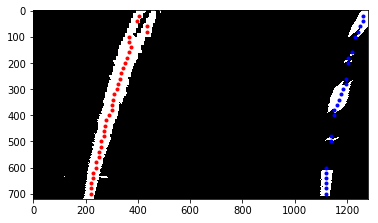

In [7]:
# find points (peaks) belonging to left and right lines
test_left_lane_pts, test_right_lane_pts = detect_lanes_pts(test_warped)

plt.figure(0)
plt.imshow(test_warped,'gray')
plt.plot(test_left_lane_pts[:,1], test_left_lane_pts[:,0], 'r.', linewidth=0.5)
plt.plot(test_right_lane_pts[:,1], test_right_lane_pts[:,0], 'b.', linewidth=0.5)

In [8]:
from numpy.linalg import pinv

def poly_fit(lane_pts):
    '''self-implemented poly-fit function'''
    x = lane_pts[:,1]
    y = lane_pts[:,0]
    
    # we find solution to x = ay^2 + by + c
    y      = np.vstack((np.square(y), y, np.ones(len(y)))) # shape is (3,) now!
    y_tp   = y.transpose() # (,3)
    coeff  = np.dot(pinv(np.dot(y,y_tp)),np.dot(y,x))
    
    return coeff

def poly_eval(X, coeff):
    '''evaluates Y value of polynomial for X with given coefficients'''
    X_square = np.square(X)
    if isinstance(X, int):
        X_ones = 1
    elif isinstance(X, float):
        X_ones = 1.0
    elif isinstance(X, range):
        X_ones = np.ones(len(X))
    else:
        X_ones = np.ones(X.shape, dtype=X.dtype)
    
    return X_square*coeff[0] + X*coeff[1] + X_ones*coeff[2]

def generate_lane_img(left_coeff, right_coeff, shape = (720,1280), lane_color = (0, 255, 0)):
    '''generate lane image (i.e. black template with green between left and right lane)'''
    img_h, img_w = shape[:]
    lane_img     = np.zeros(shape=(img_h, img_w, 3), dtype=np.uint8) 
    
    # meshgrid arrays for conditioning. 
    XX, YY       = np.meshgrid(range(0,img_w,1), range(0,img_h,1))   
        
    # Color pixels that are between left and right lanes
    lane_img[(XX > poly_eval(YY, left_coeff)) & \
             (XX < poly_eval(YY, right_coeff))] = lane_color
    
    return lane_img

def draw_lane(img):
    '''draws lane on undistorted (static) image'''
    # global arguments
    global cam_mtx
    global dist_coeff
    global T
    global Tinv
    img_h, img_w = img.shape[0:2]
    # undistort image
    undist = cv2.undistort(img, cam_mtx, dist_coeff, None, cam_mtx)
    
    # hsv colorspace for white and yellow masking
    hsv_img = cv2.cvtColor(undist, cv2.COLOR_RGB2HSV)
    
    # sobel, white and yellow masks respectively
    sobel   = sobel_mask(undist)
    white   = white_mask(hsv_img)
    yellow  = yellow_mask(hsv_img)
    binary  = (sobel | white | yellow) 
    # apply perspective transformation for bird-eye view
    warped  = cv2.warpPerspective(binary, T, (img_w, img_h))
    
    # find points (peaks) belonging to left and right lines
    left_lane_pts, right_lane_pts = detect_lanes_pts(warped)
    
    # find left and right lanes polynomial coefficients
    left_coeff  = poly_fit(left_lane_pts)
    right_coeff = poly_fit(right_lane_pts)
    
    # generate lane_img
    lane_img = generate_lane_img(left_coeff, right_coeff, img.shape[:-1])
    res      = (undist | cv2.warpPerspective(lane_img, Tinv, (img_w, img_h))) 
    return res

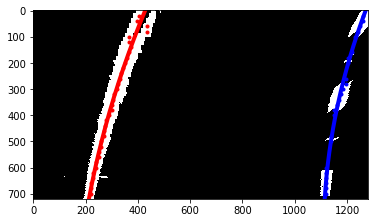

In [9]:
# find points (peaks) belonging to left and right lines
test_left_coeff  = poly_fit(test_left_lane_pts)
test_right_coeff = poly_fit(test_right_lane_pts)

# draw polynomial curve
test_y_range = range(0,720,5)
test_x_left  = poly_eval(test_y_range, test_left_coeff)
test_x_right  = poly_eval(test_y_range, test_right_coeff)

plt.figure(0)
plt.imshow(test_warped,'gray')
plt.plot(test_left_lane_pts[:,1], test_left_lane_pts[:,0], 'r.', linewidth=0.5)
plt.plot(test_right_lane_pts[:,1], test_right_lane_pts[:,0], 'b.', linewidth=0.5)
plt.plot(test_x_left[:], test_y_range[:], 'r-', linewidth=4.)
plt.plot(test_x_right[:], test_y_range[:], 'b-', linewidth=4.)

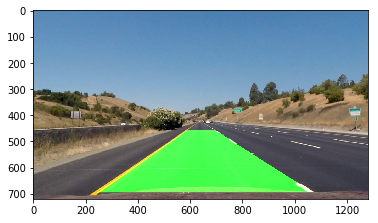

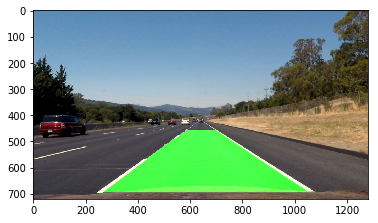

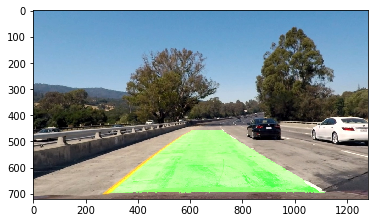

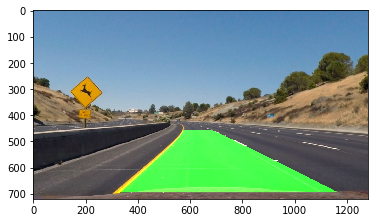

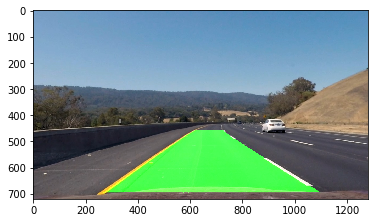

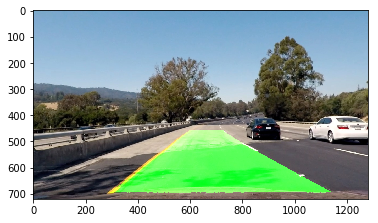

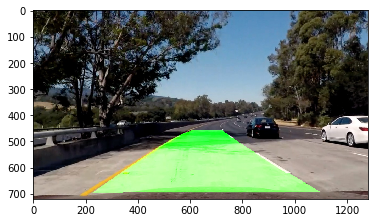

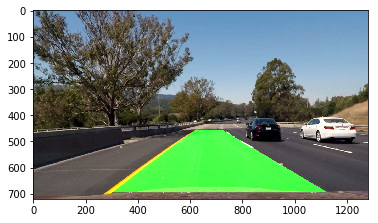

In [10]:
test_images = glob.glob('test_images/*.jpg')

# check if directory exists, if not - create 
output_img_dir = 'test_images_output/'
if not os.path.exists(output_img_dir):
    os.makedirs(output_img_dir)
    
for fname in test_images:
    res    = draw_lane(mpimg.imread(fname))
    plt.figure(fname)
    plt.imshow(res)
    mpimg.imsave(output_img_dir + fname.split('\\')[-1],res)

In [11]:
# search margin (+- around prev frame)
margin = 100

# class to handle lanes across multiple frames in a video
class video_lane:
    def __init__(self, scale_x, scale_y, decay = 0.8):
        #self.left_coeff  = np.zeros((3,0), dtype=np.float32) # history of polynomial coefficients for left lane
        #self.right_coeff  = np.zeros((3,0), dtype=np.float32) # history of polynomial coefficients for right lane
        self.left_coeff  = None
        self.right_coeff = None
        self.scale_x     = scale_x # x scale factor from pixels to meters
        self.scale_y     = scale_y # y scale factor from pixels to meters
        self.scale_coeff = np.array([scale_x/(scale_y**2), scale_x/scale_y, scale_x], dtype=float) # scale factor for polynomial coefficients
        self.decay       = decay # weights that are used to identify polynomial coefficients across multiple frames (for smoothing) 
        self.frame_cnt   = 0 # modulo frame counter, i.e. only every 5th curvature and position information is updated (for readibility and smoothness)
        self.curv_left   = 0.0 # real-time left lane curvature
        self.curv_right  = 0.0 # real-time right lane curvature
        self.position    = 0.0 # real-time curvature radius
        self.frame_curv_left  = 0.0 # last displayed left lane curvature 
        self.frame_curv_right = 0.0 # last displayed left lane curvature
        self.frame_position   = 0.0 # last displayed left lane curvature
        
    def add_coeff(self, left_coeff, right_coeff): 
        if self.left_coeff is None:
            self.left_coeff = left_coeff
        else:
            self.left_coeff = self.decay*self.left_coeff + (1-self.decay)*left_coeff
        if self.right_coeff is None:
            self.right_coeff = right_coeff
        else:
            self.right_coeff = self.decay*self.right_coeff + (1-self.decay)*right_coeff
        
    def get_coeff(self):
        return self.left_coeff, self.right_coeff

    def curvature(self, y_px):
        self.frame_cnt += 1
        y_m = self.scale_y # y in meters
        left_coeff, right_coeff = self.get_coeff()
        left_coeff_hat  = np.multiply(left_coeff, self.scale_coeff)
        right_coeff_hat = np.multiply(right_coeff, self.scale_coeff)
        # accumalated curvature (will be divided to 5 for averaging across 5 frames)
        self.curv_left  += ((1 + (2*left_coeff_hat[0]*y_m + left_coeff_hat[1])**2)**1.5) / np.absolute(2*left_coeff_hat[0])
        self.curv_right += ((1 + (2*right_coeff_hat[0]*y_m + right_coeff_hat[1])**2)**1.5) / np.absolute(2*right_coeff_hat[0])
        
        # accumalated position
        x_left         = poly_eval(y_m, left_coeff_hat)
        x_right        = poly_eval(y_m, right_coeff_hat)
        self.position += (x_left + x_right) / 2
        
        # if 5th frame, average last 5 curvatures and positions, and set for displaying on a frame
        if self.frame_cnt%5 == 0:
            self.frame_cnt = 0
            self.frame_curv_left  = self.curv_left / 5
            self.frame_curv_right = self.curv_right / 5
            self.frame_position   = self.position / 5
            self.curv_left  = 0.0
            self.curv_right = 0.0
            self.position   = 0.0
            
        return self.frame_curv_left, self.frame_curv_right, self.frame_position
        
#Convert x,y pixels to meters
scale_x = 3.7/880 # meters per pixel in x dimension
scale_y = 30 /720 # meters per pixel in y dimension
vlane = video_lane(scale_x, scale_y)

def process_video_image(img):
    '''process video image, given the following '''
    # global arguments
    global cam_mtx
    global dist_coeff
    global T
    global Tinv

    img_h, img_w = img.shape[0:2]
    
    # undistort image
    undist = cv2.undistort(img, cam_mtx, dist_coeff, None, cam_mtx)
    
    # hsv colorspace for white and yellow masking
    hsv_img = cv2.cvtColor(undist, cv2.COLOR_RGB2HSV)
    
    # sobel, white and yellow masks respectively
    sobel   = sobel_mask(undist)
    white   = white_mask(hsv_img)
    yellow  = yellow_mask(hsv_img)
    binary  = (sobel | white | yellow) 
    
    # apply perspective transformation for bird-eye view
    warped  = cv2.warpPerspective(binary, T, (img_w, img_h))
   
    # default boundary for searching lane points for left and right lane respectively
    x_bound_left    = (0, 640)
    x_bound_right   = (640, 1280)
    
    # find center points for left and right lane from the previous image
    # boundary for lane points detection for current frame is derived from it
    left_coeff, right_coeff = vlane.get_coeff()
    if left_coeff is not None:
        x_center_left  = np.int(poly_eval(700, left_coeff))
        x_bound_left   = (x_center_left - margin, x_center_left + margin)
    if right_coeff is not None:
        x_center_right = np.int(poly_eval(700, right_coeff))
        x_bound_right  = (x_center_right - margin, x_center_right + margin)
        
    # detect lane points of current frame
    left_lane_pts, right_lane_pts = detect_lanes_pts(warped, x_bound_left = x_bound_left, x_bound_right = x_bound_right, margin = margin)
   
    # find polynomial coefficients
    try:
        left_coeff  = poly_fit(left_lane_pts)
        right_coeff = poly_fit(right_lane_pts)
        vlane.add_coeff(left_coeff, right_coeff)
    except:
        # add previous 
        vlane.add_coeff(left_coeff, right_coeff)
        
    # weighted coefficients (smoothed across multiple framse)
    left_coeff, right_coeff = vlane.get_coeff()
          
    # generate lane_img
    lane_img = generate_lane_img(left_coeff, right_coeff, img.shape[:-1])
    res      = (undist | cv2.warpPerspective(lane_img, Tinv, (img_w, img_h))) 
    
    # print curvature and position data
    curv_left, curv_right, x_center = vlane.curvature(720)
    curv     = (curv_left + curv_right)/2
    position = x_center - 640*scale_x
    font = cv2.FONT_HERSHEY_SIMPLEX
    res  = cv2.putText(res, 'curvature: {:0.4f} m'.format(curv_left), (850,40), font, 1.0, (255,255,255))
    res  = cv2.putText(res, 'position: {:0.4f} m'.format(position), (850,80), font, 1.0, (255,255,255))
    return res

In [12]:
#output_vid_dir = 'test_videos_output/'
#if not os.path.exists(output_vid_dir):
#    os.makedirs(output_vid_dir)
from moviepy.editor import VideoFileClip
from IPython.display import HTML

prev_left_coeff = None
prev_right_coeff = None
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip  = clip1.fl_image(process_video_image) 
%time clip.write_videofile(project_output, audio=False) 
clip.reader.close()

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:52<00:00,  3.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 53s


In [ ]:
clip.reader.close()
clip.audio.reader.close_proc()

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))